#### image_shape= (128,128,3)

In [44]:
import os
import random
import pandas as pd
import numpy as np
from glob import glob
import tensorflow_io as tfio
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import img_to_array , array_to_img

In [45]:
# the lists that will contain the paths to the image, path
image_paths = []
# get all the mask images from the data directory
mask_paths = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
print(mask_paths[0:5])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43_mask.tif']


In [46]:
# the original images is the same excep that there is no  "_mask" in the path 
for img_path in mask_paths:
    image_paths.append(img_path.replace('_mask',''))
# now print first 5 images
print(image_paths[0:5])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif']


In [47]:
image_list_ds = tf.data.Dataset.list_files(image_paths, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_paths, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif'>, <tf.Tensor: shape=(), dtype=string, numpy=b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif'>, <tf.Tensor: shape=(), dtype=string, numpy=b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif'>, <tf.Tensor: shape=(), dtype=string, numpy=b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif'>)


In [48]:
# concatenate the image paths to form the all_dataset
image_files = tf.constant(image_paths)
masks_files = tf.constant(mask_paths)


In [49]:

dataset = tf.data.Dataset.from_tensor_slices((image_files, masks_files))
# print first three paths of the data 
for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', shape=(), dtype=string)
tf.Tensor(b'../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', shape=(), dtype=string)


#### Show Some Images

#### Preprocessing the images 

In [50]:
# function that takes both image & mask path and return the image
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tfio.experimental.image.decode_tiff(img)
    img = img[:,:,0:3]
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tfio.experimental.image.decode_tiff(mask)
    # take only the 3 channels
    mask = mask[:,:,0:3]
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask


def preprocess(image, mask):
    input_image = tf.image.resize(image, (128, 128), method='nearest')
    input_mask = tf.image.resize(mask, (128, 128), method='nearest')

    return input_image, input_mask


In [51]:
# apply the functions to all the data
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [52]:
processed_image_ds.element_spec

(TensorSpec(shape=(128, 128, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))

#### Show The Images

In [53]:
# take some images from the data 
images = [image[0]  for image in list(processed_image_ds.take(5))]
masks = [mask[1] for mask in list(processed_image_ds.take(5))]

In [54]:
# show the shape of the new mask [ for the loss fucntion ]
print(f"mask shape : {masks[0].shape}")
print(f"image shape : {images[2].shape}") 

mask shape : (128, 128, 1)
image shape : (128, 128, 3)


#### Show some images and thier mask

<Figure size 1080x1080 with 0 Axes>

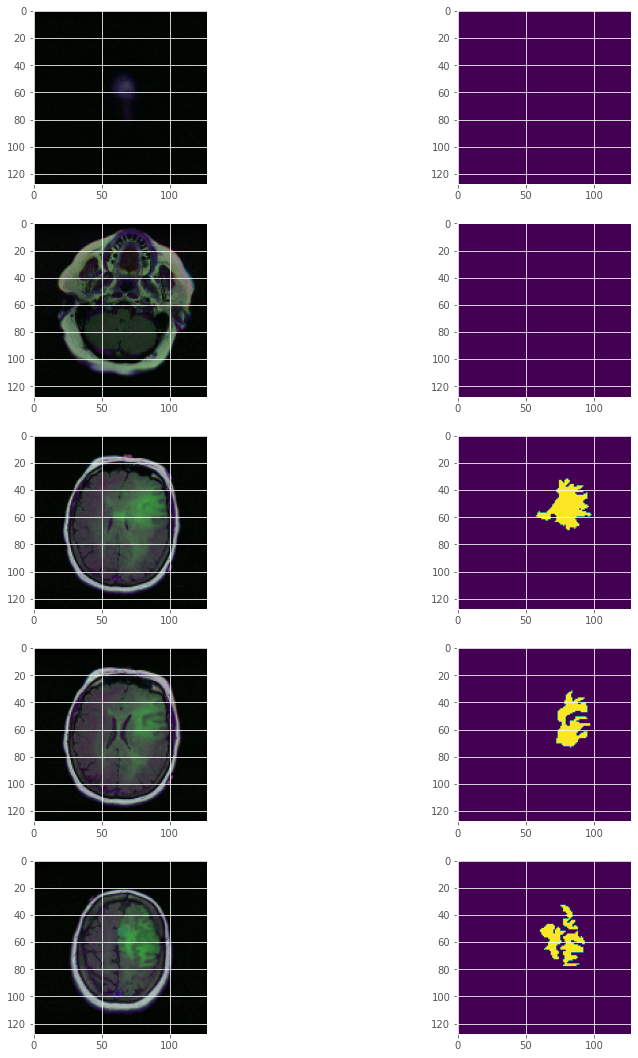

In [55]:
plt.figure(figsize=(15,15))
fig, axarr = plt.subplots(5,2,figsize=(15, 15))
axarr[0,0].imshow(images[0])
axarr[0,1].imshow(masks[0])
axarr[1,0].imshow(images[1])
axarr[1,1].imshow(masks[1])
axarr[2,0].imshow(images[2])
axarr[2,1].imshow(masks[2])
axarr[3,0].imshow(images[3])
axarr[3,1].imshow(masks[3])
axarr[4,0].imshow(images[4])
axarr[4,1].imshow(masks[4])
fig.tight_layout(pad=1.8)

### Split the data into `Train/VAl/TEST` Sets

In [56]:
# number of images in the data
len(processed_image_ds) 

3929

##### Split the data into 90% train 5% Test and 5% Val

In [57]:
# Cash the data 
BUFFER_SIZE = 1000
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
Full_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [58]:
Full_dataset.element_spec

(TensorSpec(shape=(None, 128, 128, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [59]:
# number of batches in the data
len_data = len(Full_dataset) 
len_data

123

In [60]:
# split the data
train_size = int(len_data *.9 )
val_size = int(len_data *.05) 
test_size = len_data - train_size - val_size
train_size , test_size ,val_size

(110, 7, 6)

In [61]:
train_ds = Full_dataset.take(train_size)
test_ds = Full_dataset.skip(train_size).take(test_size)
val_ds = Full_dataset.skip(train_size + test_size) 

In [62]:
len(train_ds),len(test_ds),len(val_ds)

(110, 7, 6)

In [63]:
# train_ds = (
#     train_ds
#     .cache()
#     .shuffle(BUFFER_SIZE)
#     .batch(BATCH_SIZE)
#     .repeat()
#     .prefetch(buffer_size=tf.data.AUTOTUNE))
# val_ds = (
#     val_ds
#     .cache()
#     .shuffle(BUFFER_SIZE)
#     .batch(BATCH_SIZE)
#     .repeat()
#     .prefetch(buffer_size=tf.data.AUTOTUNE))

In [64]:
print(train_ds.element_spec)

(TensorSpec(shape=(None, 128, 128, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))


In [65]:
# Get the first 5 elements from the dataset
for i, (images, labels) in enumerate(train_ds):
    if i < 5:
        print(f"Batch {i+1}:")
        print("Images:", images.numpy())  # Convert tensors to numpy arrays for easy viewing
        print("Labels:", labels.numpy())  # Convert labels to numpy arrays
    else:
        break


Batch 1:
Images: [[[[0.00784314 0.00392157 0.00784314]
   [0.00392157 0.01176471 0.00392157]
   [0.00784314 0.01960784 0.00392157]
   ...
   [0.00784314 0.01960784 0.00392157]
   [0.00784314 0.01176471 0.01176471]
   [0.00392157 0.01176471 0.00784314]]

  [[0.00392157 0.00784314 0.00392157]
   [0.00392157 0.00784314 0.00392157]
   [0.00784314 0.01176471 0.00784314]
   ...
   [0.00392157 0.01176471 0.00392157]
   [0.00392157 0.01176471 0.00784314]
   [0.00784314 0.01176471 0.01176471]]

  [[0.00392157 0.01176471 0.00784314]
   [0.00392157 0.01176471 0.00784314]
   [0.00392157 0.00784314 0.01176471]
   ...
   [0.00784314 0.02352941 0.00784314]
   [0.00392157 0.00392157 0.00784314]
   [0.00392157 0.03137255 0.00392157]]

  ...

  [[0.00392157 0.01176471 0.00392157]
   [0.00784314 0.00392157 0.00392157]
   [0.00392157 0.01176471 0.00784314]
   ...
   [0.00392157 0.01568628 0.00784314]
   [0.00784314 0.01176471 0.00784314]
   [0.00784314 0.00784314 0.00392157]]

  [[0.00784314 0.01176471 0.

### TEACHER MODEL

### The model consist of three parts:
* Downsampling convolutional `Normal Convolution`
* Upsampling convolutional   `Transpose Convolution`
* Skip connection `Residual Connection`f

In [66]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

#### Downsapling Block
* Each conv block will consist of two convolutional layers

In [67]:
def conv_block(inputs=None, n_filters=32, dropout=0, max_pooling=True, block_name="conv_block"):
    conv = Conv2D(
                  n_filters, 
                  3,  
                  activation="relu",
                  padding="same", 
                  kernel_initializer="he_normal",  
                  name=f'{block_name}_conv1'
                 )(inputs)
    conv = Conv2D(
                  n_filters,  
                  3, 
                  activation="relu",
                  padding="same",  
                  kernel_initializer="he_normal",  
                  name=f'{block_name}_conv2'
                 )(conv)
    if dropout > 0:
        conv = Dropout(dropout, name=f'{block_name}_dropout')(conv)
    if max_pooling:
        out_to_next = MaxPooling2D(2, name=f'{block_name}_maxpool')(conv)
    else:
        out_to_next = conv

    out_to_skip = conv
    return out_to_next, out_to_skip


#### Upsampling block
* it will consist of Transpose layer for the upsampling
* then followed by  two normal convolution

In [68]:
def upsampling_block(previos_output, skip_output, n_filters=32, block_name="upsample_block"):
    up_sample = Conv2DTranspose(
                         n_filters,    
                         3,    
                         strides=(2, 2),  
                         padding="same",  
                         name=f'{block_name}_up_sample'
                        )(previos_output)
    concate = concatenate([up_sample, skip_output], axis=3, name=f'{block_name}_concatenate')
    conv = Conv2D(n_filters,   
                  3,     
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal", 
                  name=f'{block_name}_conv1')(concate)
    conv = Conv2D(n_filters,   
                  3,    
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal", 
                  name=f'{block_name}_conv2')(conv)
    return conv


### Now, build the whole model as in the figure above

In [69]:
def unet_model(input_size=(256, 256, 3), n_filters=32):
    # start with the downsampling part
    inputs = Input(input_size)
    conv_block1 = conv_block(inputs, n_filters, block_name="conv_block1")
    conv_block2 = conv_block(conv_block1[0], n_filters * 2, block_name="conv_block2")
    conv_block3 = conv_block(conv_block2[0], n_filters * 4, block_name="conv_block3")
    conv_block4 = conv_block(conv_block3[0], n_filters * 8, dropout=0.3, block_name="conv_block4")
    conv_block5 = conv_block(conv_block4[0], n_filters * 16, dropout=0.3, max_pooling=False, block_name="conv_block5")
    
    # The upsampling part
    up_block1 = upsampling_block(conv_block5[0], conv_block4[1], n_filters * 8, block_name="up_block1")
    up_block2 = upsampling_block(up_block1, conv_block3[1], n_filters * 4, block_name="up_block2")
    up_block3 = upsampling_block(up_block2, conv_block2[1], n_filters * 2, block_name="up_block3")
    up_block4 = upsampling_block(up_block3, conv_block1[1], n_filters, block_name="up_block4")

    conv9 = Conv2D(n_filters,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal',
                   name='conv9')(up_block4)

    # output part
    conv10 = Conv2D(2, 1, padding="same", name='conv10')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


In [70]:
img_height = 128
img_width = 128
num_channels = 3
unet = unet_model((img_height, img_width, num_channels))

In [71]:
unet.summary() 

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv_block1_conv1 (Conv2D)      (None, 128, 128, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv_block1_conv2 (Conv2D)      (None, 128, 128, 32) 9248        conv_block1_conv1[0][0]          
__________________________________________________________________________________________________
conv_block1_maxpool (MaxPooling (None, 64, 64, 32)   0           conv_block1_conv2[0][0]          
____________________________________________________________________________________________

In [72]:
from tensorflow.keras import backend as K

In [73]:
# compile the model
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
#         plt.axis('off')
    plt.show()

(32, 128, 128, 1)
(32, 128, 128, 3)


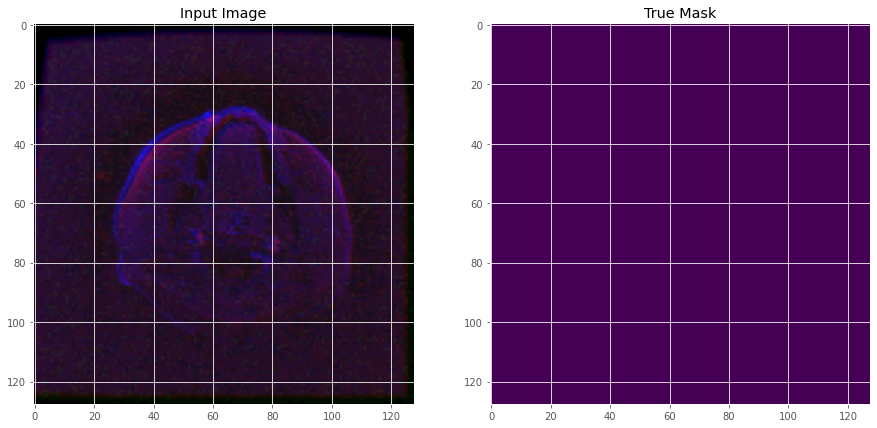

In [75]:
for image, mask in train_ds.take(1):
    sample_image, sample_mask = image[20], mask[20]
    print(mask.shape)
    print(image.shape)
display([sample_image, sample_mask])

In [76]:
# train the model
history = unet.fit(train_ds,
                   validation_data=val_ds,
                   callbacks = [tf.keras.callbacks.ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)],
                   epochs=30,    
                  )

Epoch 1/30
110/110 [==============================] - 20s 156ms/step - loss: 0.1006 - accuracy: 0.9808 - val_loss: 0.0310 - val_accuracy: 0.9901

Epoch 00001: val_loss improved from inf to 0.03098, saving model to unet_brain_mri_seg.hdf5
Epoch 2/30
110/110 [==============================] - 10s 89ms/step - loss: 0.0273 - accuracy: 0.9899 - val_loss: 0.0251 - val_accuracy: 0.9900

Epoch 00002: val_loss improved from 0.03098 to 0.02509, saving model to unet_brain_mri_seg.hdf5
Epoch 3/30
110/110 [==============================] - 10s 89ms/step - loss: 0.0256 - accuracy: 0.9919 - val_loss: 0.0178 - val_accuracy: 0.9948

Epoch 00003: val_loss improved from 0.02509 to 0.01776, saving model to unet_brain_mri_seg.hdf5
Epoch 4/30
110/110 [==============================] - 10s 89ms/step - loss: 0.0226 - accuracy: 0.9933 - val_loss: 0.0173 - val_accuracy: 0.9945

Epoch 00004: val_loss improved from 0.01776 to 0.01733, saving model to unet_brain_mri_seg.hdf5
Epoch 5/30
110/110 [===================

#### <span style='color:#2E8BC0'>Show model performance `History` </span>

Text(0.5, 1.0, 'Accuraccy Curve')

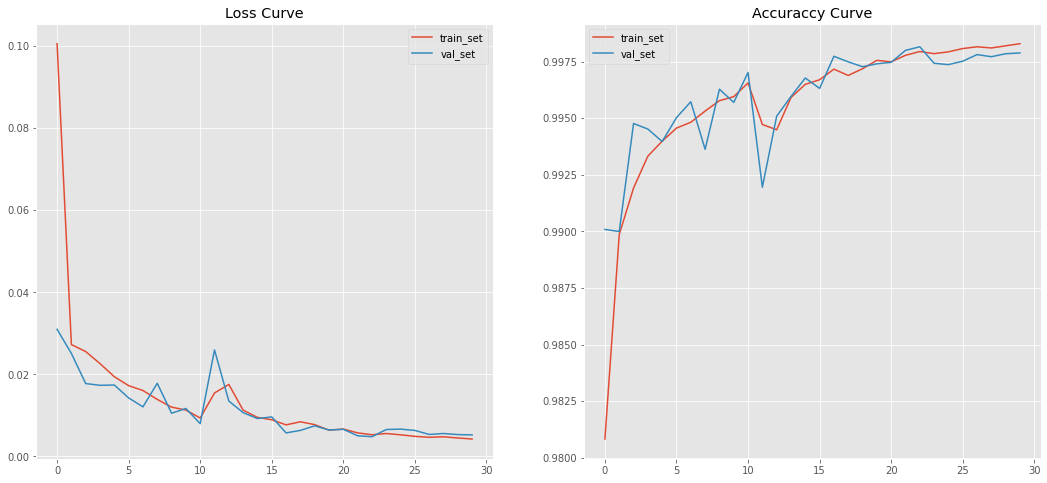

In [77]:
plt.style.use("ggplot")
plt.figure(figsize=(18, 8))
# the loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_set')
plt.plot(history.history['val_loss'], label='val_set')
plt.legend()
plt.title('Loss Curve')
# the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_set')
plt.plot(history.history['val_accuracy'], label='val_set')
plt.legend()
plt.title('Accuraccy Curve')

In [78]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [79]:
def display(display_list):
    plt.figure(figsize=(15, 50))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [80]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])

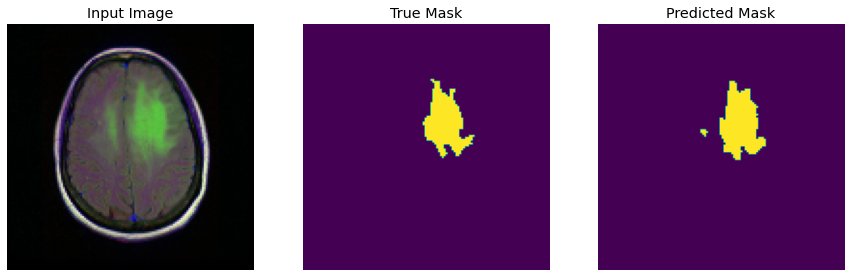

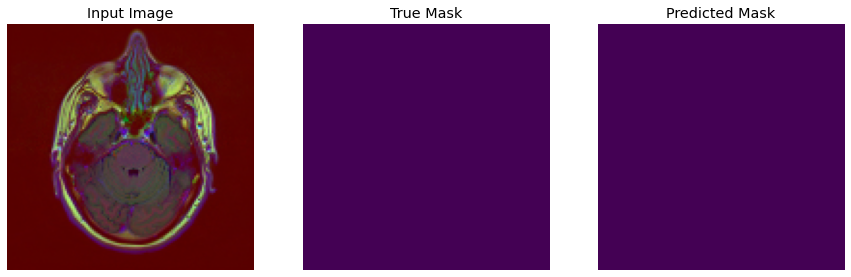

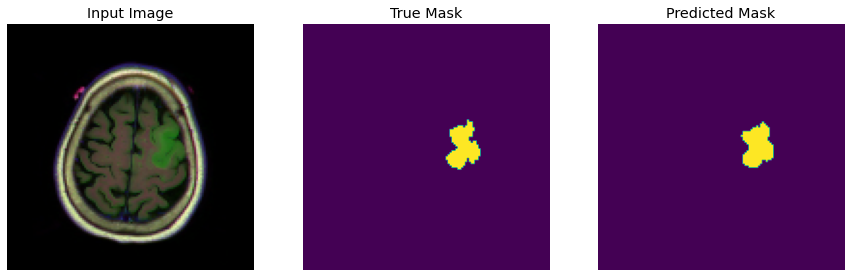

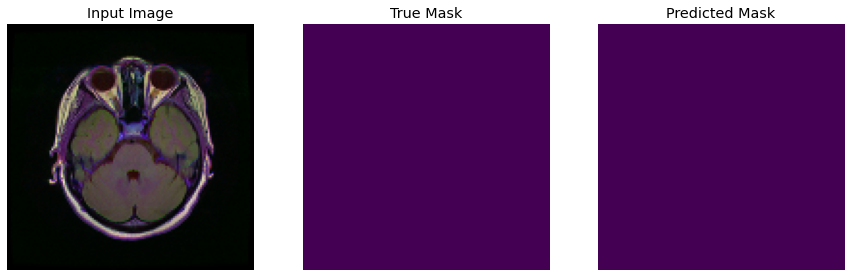

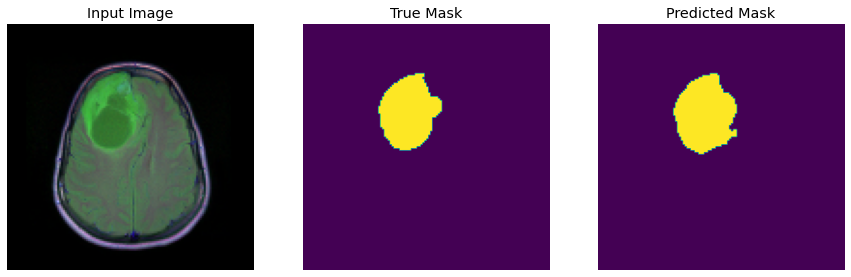

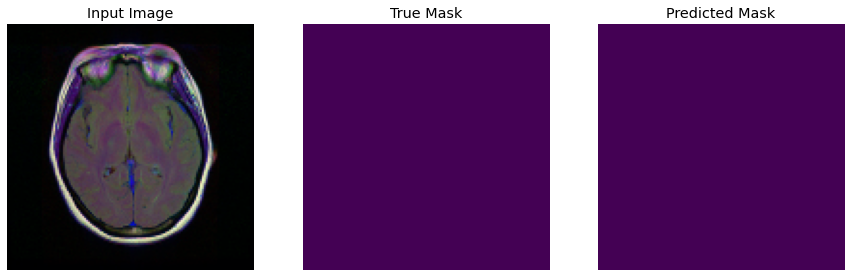

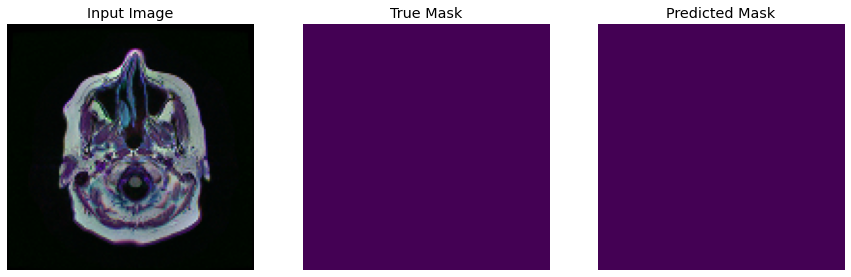

In [81]:
show_predictions(test_ds,20)

In [82]:
for images, labels in train_ds.take(1):
    print(images.shape)

(32, 128, 128, 3)


In [83]:
# # Distillation loss for training
# def distillation_loss(y_true, y_pred, teacher_logits, alpha=0.5, temperature=5):
#     student_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred)
#     teacher_loss = tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_logits / temperature, axis=-1),
#                                                   tf.nn.softmax(y_pred / temperature, axis=-1))
#     return alpha * student_loss + (1 - alpha) * teacher_loss

# # Standard loss for evaluation
# standard_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


### Student Model 

In [84]:
from tensorflow.keras.layers import Input, SeparableConv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def optimized_res_unet(input_shape=(128, 128, 3), num_classes=2):
    def conv_block(x, filters, kernel_size=(3, 3), padding='same', regularizer=l2(1e-4)):
        x = SeparableConv2D(filters, kernel_size, padding=padding, kernel_regularizer=regularizer)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)  
        x = Dropout(0.3)(x)  
        return x

    inputs = Input(input_shape)

    # Downsampling path
    x1 = conv_block(inputs, 16)
    x1 = conv_block(x1, 16)
    x1_pool = MaxPooling2D((2, 2))(x1)

    x2 = conv_block(x1_pool, 32)
    x2 = conv_block(x2, 32)
    x2_pool = MaxPooling2D((2, 2))(x2)

    x3 = conv_block(x2_pool, 64)
    x3 = conv_block(x3, 64)
    x3_pool = MaxPooling2D((2, 2))(x3)

    x4 = conv_block(x3_pool, 128)
    x4 = conv_block(x4, 128)
    x4_pool = MaxPooling2D((2, 2))(x4)

    # Additional Downscaling
    x8 = conv_block(x4_pool, 256)
    x8 = conv_block(x8, 256)

    # Upsampling path
    x9 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x8)
    x9 = Concatenate()([x9, x4])
    x9 = conv_block(x9, 128)
    x9 = conv_block(x9, 128)

    x5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x9)
    x5 = Concatenate()([x5, x3])
    x5 = conv_block(x5, 64)
    x5 = conv_block(x5, 64)

    x6 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x5)
    x6 = Concatenate()([x6, x2])
    x6 = conv_block(x6, 32)
    x6 = conv_block(x6, 32)

    x7 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(x6)
    x7 = Concatenate()([x7, x1])
    x7 = conv_block(x7, 16)
    x7 = conv_block(x7, 16)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(x7)

    model = Model(inputs, outputs)
    return model


student_unet = optimized_res_unet(input_shape=(128, 128, 3), num_classes=2)
student_unet.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d_18 (SeparableC (None, 128, 128, 16) 91          input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 128, 16) 64          separable_conv2d_18[0][0]        
__________________________________________________________________________________________________
leaky_re_lu_18 (LeakyReLU)      (None, 128, 128, 16) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [85]:
def dice_coef(y_true, y_pred, smooth=100):
    if len(K.shape(y_pred)) > 2:
        y_pred = tf.argmax(y_pred, axis=-1)  
        y_pred = tf.cast(y_pred, dtype=tf.float32)  

    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    
    if K.shape(y_true_flat) != K.shape(y_pred_flat):
        raise ValueError(f"Shape mismatch: y_true shape {K.shape(y_true_flat)}, y_pred shape {K.shape(y_pred_flat)}")
    
    intersect = K.sum(y_true_flat * y_pred_flat)
    union = K.sum(y_true_flat) + K.sum(y_pred_flat)
    
    return (2 * intersect + smooth) / (union + smooth)


def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

def iou(y_true, y_pred, smooth=100):
    if len(K.shape(y_pred)) > 2:
        y_pred = tf.argmax(y_pred, axis=-1)  
        y_pred = tf.cast(y_pred, dtype=tf.float32)  

    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    
    if K.shape(y_true_flat) != K.shape(y_pred_flat):
        raise ValueError(f"Shape mismatch: y_true shape {K.shape(y_true_flat)}, y_pred shape {K.shape(y_pred_flat)}")
    
    intersect = K.sum(y_true_flat * y_pred_flat)
    summ= K.sum(y_true_flat+y_pred_flat)
    return (intersect+smooth)/(summ-intersect+smooth)

In [86]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

student_unet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=dice_loss,
    metrics=['accuracy', iou, dice_coef]
)

callback = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5)


In [87]:
# # compile the model
# student_unet.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [88]:
def distillation_loss(y_true, y_pred, teacher_logits, alpha=0.5, beta=0.5,
                               temperature=5, weight_decay=1e-5):
    student_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred)
    
    soft_teacher = tf.nn.softmax(teacher_logits / temperature, axis=-1)
    soft_student = tf.nn.softmax(y_pred / temperature, axis=-1)
    teacher_loss = tf.keras.losses.KLDivergence()(soft_teacher, soft_student)
    
    l2_regularizer = tf.reduce_sum([tf.nn.l2_loss(w) for w in y_pred])  # Replace with `trainable_weights` if applicable
    
    total_loss = alpha * student_loss + beta * teacher_loss + weight_decay * l2_regularizer
    
    return total_loss


In [89]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    y_true = tf.reshape(y_true, tf.shape(y_pred))
    y_pred = tf.nn.softmax(y_pred, axis=-1)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    y_true = tf.reshape(y_true, tf.shape(y_pred))
    y_pred = tf.nn.softmax(y_pred, axis=-1)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

## update

In [90]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [91]:
standard_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

for epoch in range(30):  # Train for a few epochs
    print(f"Epoch {epoch + 1}")
    for images, labels in train_ds:
        with tf.GradientTape() as tape:
            logits = student_unet(images, training=True)  
            teacher_logits = unet(images, training=False)  

            loss = distillation_loss(labels, logits, teacher_logits)

        grads = tape.gradient(loss, student_unet.trainable_weights)
        student_unet.optimizer.apply_gradients(zip(grads, student_unet.trainable_weights))

    val_loss = 0
    val_accuracy = 0
    val_dice = 0
    val_iou = 0
    for val_images, val_labels in val_ds:
        val_logits = student_unet(val_images, training=False)
        val_loss += standard_loss(val_labels, val_logits).numpy()
        val_accuracy += tf.keras.metrics.SparseCategoricalAccuracy()(val_labels, val_logits).numpy()
        val_dice += dice_coef(val_labels, val_logits).numpy()
        val_iou += iou(val_labels, val_logits).numpy()

    val_loss /= len(val_ds)
    val_accuracy /= len(val_ds)
    val_dice /= len(val_ds)
    val_iou /= len(val_ds)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Dice: {val_dice}, IoU: {val_iou}")

test_loss = 0
test_accuracy = 0
test_dice = 0
test_iou = 0
for test_images, test_labels in test_ds:
    test_logits = student_unet(test_images, training=False)
    test_loss += standard_loss(test_labels, test_logits).numpy()
    test_accuracy += tf.keras.metrics.SparseCategoricalAccuracy()(test_labels, test_logits).numpy()
    test_dice += dice_coef(test_labels, test_logits).numpy()
    test_iou += iou(test_labels, test_logits).numpy()

test_loss /= len(test_ds)
test_accuracy /= len(test_ds)
test_dice /= len(test_ds)
test_iou /= len(test_ds)

print(f"Student Model Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Dice: {test_dice}, IoU: {test_iou}")


Epoch 1


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


Validation Loss: 0.6069766581058502, Validation Accuracy: 0.987406849861145, Dice: 0.01736836601048708, IoU: 0.01736836601048708
Epoch 2
Validation Loss: 0.45402927199999493, Validation Accuracy: 0.9889535109202067, Dice: 0.018633976268271606, IoU: 0.018633976268271606
Epoch 3
Validation Loss: 0.3063962906599045, Validation Accuracy: 0.9880091746648153, Dice: 0.017960403269777696, IoU: 0.017960403269777696
Epoch 4
Validation Loss: 0.21606118977069855, Validation Accuracy: 0.9872554043928782, Dice: 0.016119969853510458, IoU: 0.016119969853510458
Epoch 5
Validation Loss: 0.1562161942323049, Validation Accuracy: 0.9863714575767517, Dice: 0.015463329230745634, IoU: 0.015463329230745634
Epoch 6
Validation Loss: 0.10758469626307487, Validation Accuracy: 0.9910450081030527, Dice: 0.02423928740123908, IoU: 0.02423928740123908
Epoch 7
Validation Loss: 0.09037047997117043, Validation Accuracy: 0.9891209006309509, Dice: 0.01989114594956239, IoU: 0.01989114594956239
Epoch 8
Validation Loss: 0.0788

## visualise the student model prediction and ground truth


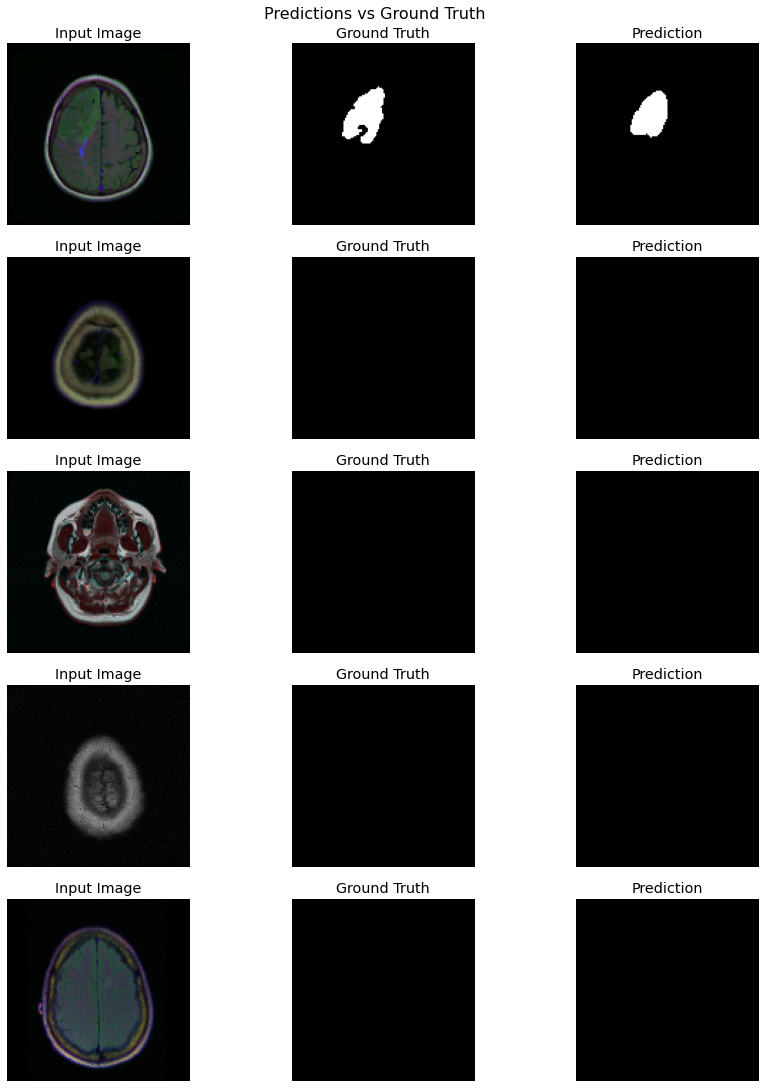

In [92]:
import matplotlib.pyplot as plt

def display_predictions(model, test_dataset, num_samples=5):
    samples = iter(test_dataset.unbatch().take(num_samples))
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
    fig.tight_layout()
    fig.suptitle('Predictions vs Ground Truth', y=1.02, fontsize=16)

    for i in range(num_samples):
        test_image, test_label = next(samples)
        test_image_expanded = tf.expand_dims(test_image, axis=0)
        
        prediction = model.predict(test_image_expanded, verbose=0)
        
        if prediction.shape[-1] == 1: 
            predicted_mask = (prediction[0] > 0.5).astype("uint8")
        else:  
            predicted_mask = np.argmax(prediction[0], axis=-1)
        
        axes[i, 0].imshow(test_image.numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(test_label.numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(predicted_mask, cmap='gray')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

    plt.show()

display_predictions(student_unet, test_ds, num_samples=5)


In [93]:
# # compile the model
# student_unet.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [94]:
# history = student_unet.fit(train_ds,
#                    validation_data=val_ds,
#                    callbacks=[tf.keras.callbacks.ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)],
#                    epochs=30)
